In [1]:
library(lpirfs)
library(gridExtra)
library(ggplot2)
library(readxl)
library(httr)

library(reshape2)
library(purrr) 

In [ ]:
run_lp_model <- function(data, endog, exog, max_lags, newey_lags = NULL, horizons = 10, signif, lags_exog = NULL, cumulative = FALSE) {
  # Map confidence levels to the corresponding values
  confint_map <- c("0.05" = 1.96, "0.32" = 1)

  # Validate significance level
  if (!as.character(signif) %in% names(confint_map)) {
    stop("Invalid significance level. Use 0.05 for 95% or 0.32 for 68%.")
  }

  # Process exogenous variables
  if (!is.null(exog)) {
    exog_data <- data[, exog, drop = FALSE]
    if (is.null(lags_exog)) {
        lags_exog = max_lags
    }
  } else {
    exog_data = NULL
  }

  # Select endogenous variables and ensure numeric conversion
  endog_data <- data[, endog, drop = FALSE]
  endog_data <- data.frame(lapply(endog_data, as.numeric))

  # Run the local projections model
  results_lin <- lp_lin(
    endog_data, 
    exog_data = exog_data,
    lags_endog_lin = max_lags,  
    trend          = 0,  
    shock_type     = 1,  
    confint        = confint_map[as.character(signif)], 
    nw_lag         = newey_lags,
    hor            = horizons,
    lags_exog = lags_exog
  )

  title_text <- paste0(
    "LocalProjection ", 
    if (!is.null(exog)) "(with exog)" else "(without exog)", 
    if (cumulative) " - Cumulative" else "",
    " - signif ", 1 - signif
  )

  plotlp(results_lin, endog = endog, title_text = title_text)

  # Process and print results with cumulative option
  pretty_results(results_lin = results_lin, endog_vars = endog, cumulative = cumulative)

  return(results_lin)
}

plotlp <- function(results_lin, endog, title_text) {
  # Generate and return plots
  linear_plots <- plot_lin(results_lin)

  print(title_text)
  
  # Show all plots
  lin_plots_all <- sapply(linear_plots, ggplotGrob)

  final_plot <- marrangeGrob(lin_plots_all, nrow = length(endog), ncol = length(endog), top = grid::textGrob(title_text, gp = grid::gpar(fontsize = 14, fontface = "bold")))

  print(final_plot)
}

pretty_results <- function(results_lin, endog_vars, cumulative = FALSE) {
  # Extract IRF values, lower and upper bounds
  irf_array <- results_lin$irf_lin_mean
  lower_bound_array <- results_lin$irf_lin_low
  upper_bound_array <- results_lin$irf_lin_up

  # Get dimensions
  dims <- dim(irf_array)
  n_endog <- dims[1]  # Number of endogenous variables (responses)
  n_horizons <- dims[2]  # Number of horizons
  n_impulses <- dims[3]  # Number of impulses

  # Create index grid
  indices <- expand.grid(
    impulse = 1:n_impulses,
    response = 1:n_endog,
    horizon = 1:n_horizons
  )

  # Flatten all arrays into vectors
  irf_values <- as.vector(irf_array)
  lower_values <- as.vector(lower_bound_array)
  upper_values <- as.vector(upper_bound_array)

  # Create dataframe
  irf_df <- data.frame(
    indices,
    irf_value = irf_values,
    lower_bound = lower_values,
    upper_bound = upper_values
  )

  # Exclude rows where impulse == response
  irf_df <- subset(irf_df, impulse != response)

  # Order by impulse, response, then horizon
  irf_df <- irf_df[order(irf_df$impulse, irf_df$response, irf_df$horizon), ]

  # Apply cumulative sum if needed
  if (cumulative) {
    irf_df <- irf_df %>%
      dplyr::group_by(impulse, response) %>%
      dplyr::mutate(
        irf_value = cumsum(irf_value),
        lower_bound = cumsum(lower_bound),
        upper_bound = cumsum(upper_bound)
      ) %>%
      dplyr::ungroup()
  }

  # Remove row names (drop index numbers)
  row.names(irf_df) <- NULL

  irf_df <- as.data.frame(irf_df)

  # Map impulse and response numbers to names
  irf_named_df <- irf_df
  irf_named_df$impulse <- endog_vars[irf_named_df$impulse]
  irf_named_df$response <- endog_vars[irf_named_df$response]

  # Split into a list of dataframes by impulse-response pair
  irf_list <- split(irf_named_df, list(irf_named_df$impulse, irf_named_df$response), drop = TRUE)

  # Print all dataframes in the list
  lapply(irf_list, print)
}


In [14]:
# Example of how to call the function
url <- "https://github.com/mbarrena/tesis/raw/refs/heads/main/data/Data%20trimestral%201950%20a%202023%20con%20DUMMIES%20outliers%20(por%20trimestre).xlsx"
temp_file <- tempfile(fileext = ".xlsx")
GET(url, write_disk(temp_file, overwrite = TRUE))

# Read the `data` from the Excel file
data <- read_excel(temp_file)

Response [https://raw.githubusercontent.com/mbarrena/tesis/refs/heads/main/data/Data%20trimestral%201950%20a%202023%20con%20DUMMIES%20outliers%20(por%20trimestre).xlsx]
  Date: 2025-03-23 16:04
  Status: 200
  Content-Type: application/octet-stream
  Size: 57.9 kB
<ON DISK>  /var/folders/59/6k0yx0n916gg1mdb04zs42rm0000gn/T//RtmpBUXCO0/file6b3f2b8fdc8b.xlsxNULL

[1] "LocalProjection (with exog) - Cumulative - signif 0.95"
# A tibble: 11 × 6
   impulse   response horizon irf_value lower_bound upper_bound
   <chr>     <chr>      <int>     <dbl>       <dbl>       <dbl>
 1 ipc_ajust E              1      39.3        39.3        39.3
 2 ipc_ajust E              2      54.9      -185.        295. 
 3 ipc_ajust E              3     649.        203.       1095. 
 4 ipc_ajust E              4    1170.       -108.       2447. 
 5 ipc_ajust E              5    1172.       -106.       2450. 
 6 ipc_ajust E              6    1172.       -110.       2455. 
 7 ipc_ajust E              7    1206.        -84.0      2496. 
 8 ipc_ajust E              8    1258.        -53.1      2569. 
 9 ipc_ajust E              9    1258.        -53.1      2569. 
10 ipc_ajust E             10    1258.        -53.1      2569. 
11 ipc_ajust E             11    1258.        -53.1      2569. 
# A tibble: 11 × 6
   impulse response horizon irf_value lower_bound upper_bound
   <chr

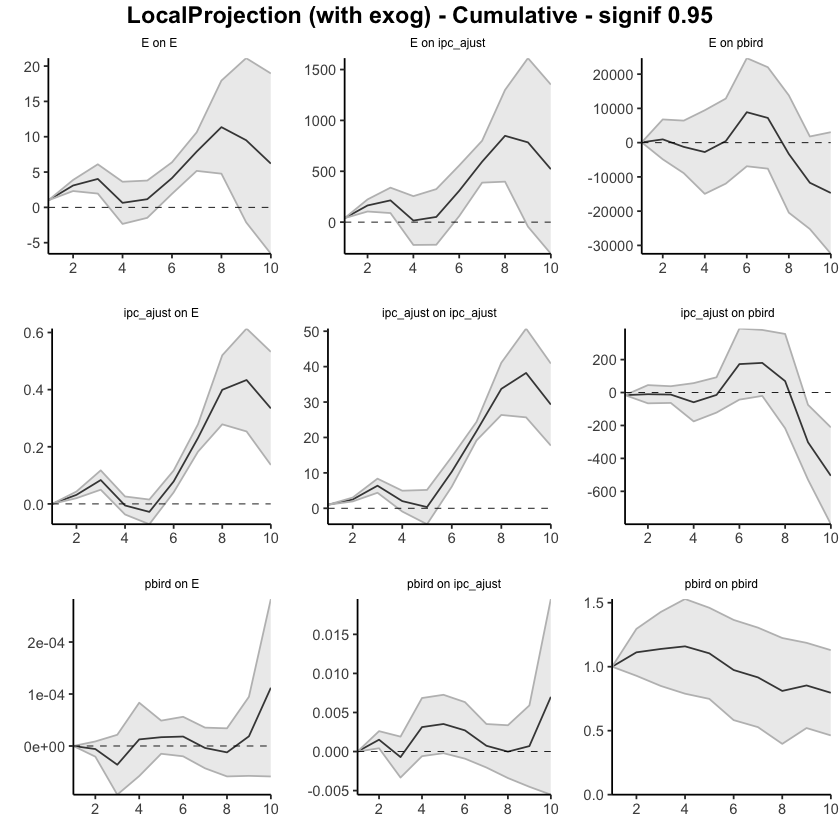

In [15]:
res <- run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, newey_lags = 4, signif = 0.05, cumulative=TRUE)
#run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, newey_lags = 4, signif = 0.32)
#run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, signif = 0.05)
#run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, signif = 0.32)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, newey_lags = 4, signif = 0.05)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, newey_lags = 4, signif = 0.32)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, signif = 0.05)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, signif = 0.32)

In [5]:
interest_rules_var_data(res)


ERROR: Error in interest_rules_var_data(res): could not find function "interest_rules_var_data"
